Example notebook for running the scripted ICA.

In [1]:
from astropy.io import fits
import sys
sys.path.append("/Users/trevormccaffrey/Dropbox/ICA_module/")
#sys.path.append("/Users/Trevor1/Dropbox/ICA_module/")
import run_ICA_r20_components
sys.path.append("/Users/trevormccaffrey/Dropbox/HST/HSTCode/")
import Cut_Edge_Pix_TVM
import Small_Pix_Filter_TVM
import spec_morph
import plot_ICA
import matplotlib.pyplot as plt
import numpy as np

First test on a $z\sim2$ SDSS quasar.  This is the "base case" that should definitely work!

In [2]:
!ls

__pycache__                        icascript_rebin.ipynb
components                         plot_ICA.py
icascript_example.ipynb            run_ICA_r20_components.py
icascript_preprocess_example.ipynb spec-6715-56449-0294.fits


In [3]:
spec = fits.open("spec-6715-56449-0294.fits")
zSDSS = 1.99703

waveSDSS = 10.**spec[1].data["LOGLAM"] / (1+zSDSS)
fluxSDSS = spec[1].data["FLUX"] ; norm_coeff = np.nanmedian(fluxSDSS) ; fluxSDSS /= norm_coeff
errsSDSS = 1. / np.sqrt(spec[1].data["IVAR"]) ; errsSDSS /= norm_coeff
maskSDSS = spec[1].data["AND_MASK"]
maskSDSS[maskSDSS>0] = 1. 

/Users/trevormccaffrey/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in true_divide
  


In [4]:
np.unique(maskSDSS)

array([0, 1], dtype=int32)

First mask bad pix or morph?

For now, I will try to mask NALs before the initial fit.

In [5]:
flux_median_61p = Small_Pix_Filter_TVM.SDSS_pixel_filter(waveSDSS, fluxSDSS, 61)

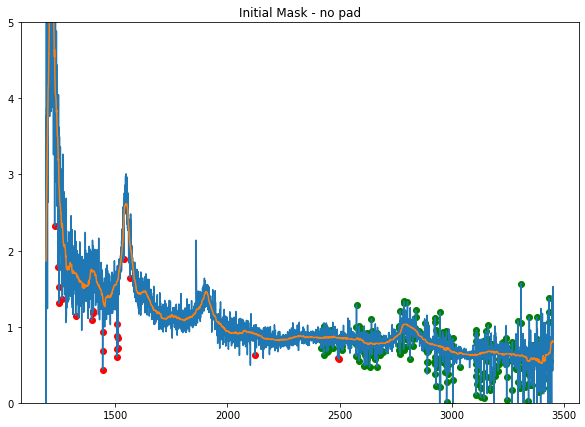

In [6]:
fig = plt.figure(figsize=(10,7))
plt.plot(waveSDSS, fluxSDSS)
plt.plot(waveSDSS, flux_median_61p)
plt.scatter(waveSDSS[(flux_median_61p-fluxSDSS > 3*errsSDSS)], 
            fluxSDSS[(flux_median_61p-fluxSDSS > 3*errsSDSS)], color="r", label="NAL candidates")
plt.scatter(waveSDSS[maskSDSS>0], fluxSDSS[maskSDSS>0], color="g", label="SDSS mask")
plt.ylim(0,5)
plt.title("Initial Mask - no pad")
plt.show()

In [7]:
maskSDSS[(flux_median_61p-fluxSDSS > 3*errsSDSS)] = 2.

In [8]:
#Pad the NAL mask three pixels each side
for i in range(len(waveSDSS)):
    if maskSDSS[i]==2.:
        maskSDSS[i-3:i+3+1] = 3. #this keeps from masking the entire spectrum in the for loop!
maskSDSS[maskSDSS==3] = 2 #save them all as two

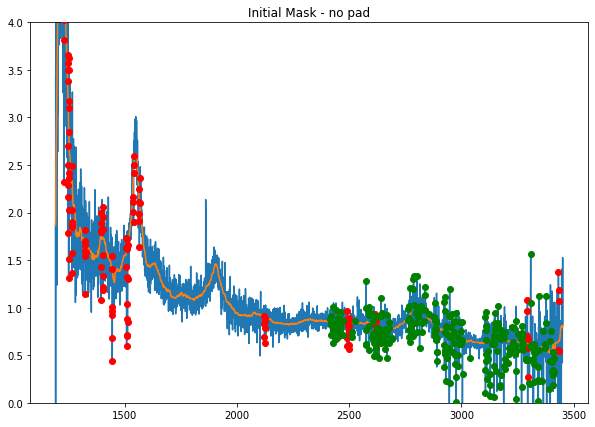

In [9]:
fig = plt.figure(figsize=(10,7))
plt.plot(waveSDSS, fluxSDSS)
plt.plot(waveSDSS, flux_median_61p)
plt.scatter(waveSDSS[maskSDSS==2], 
            fluxSDSS[maskSDSS==2], color="r", label="NAL candidates", zorder=3)
plt.scatter(waveSDSS[maskSDSS==1], fluxSDSS[maskSDSS==1], color="g", label="SDSS mask", zorder=3)
plt.ylim(0,4)
plt.title("Initial Mask - no pad")
plt.show()

In [10]:
wave_ica, flux_ica = run_ICA_r20_components.main_ICA(waveSDSS, fluxSDSS, errsSDSS, maskSDSS, name="", 
                                                     ica_path="/Users/trevormccaffrey/Dropbox/ICA_module/components/",
                                                     plot_spectrum=False, CHISQ=True, comps_use=None)

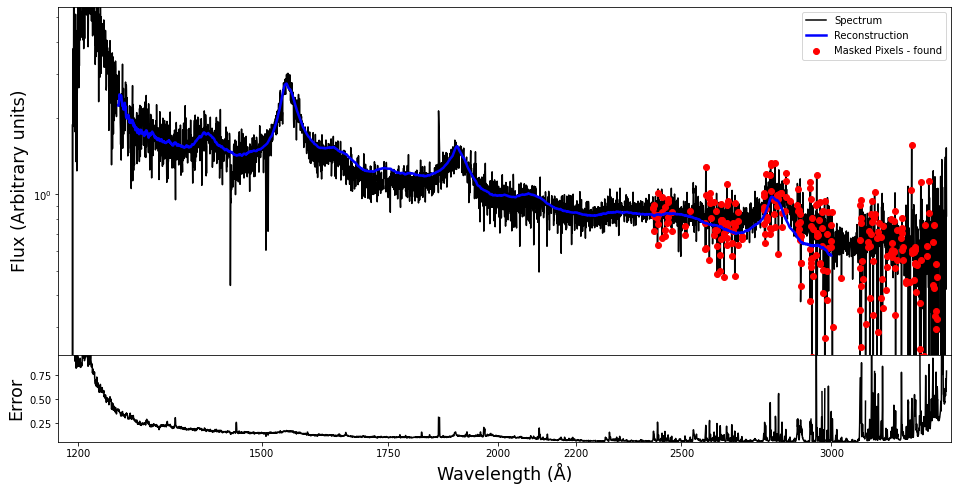

In [11]:
plot_ICA.spec_wreconstruction(waveSDSS, fluxSDSS, errsSDSS, maskSDSS, wave_ica, flux_ica)

Now morph

In [13]:
fluxSDSS_morph, morph_coeff = spec_morph.morph2(waveSDSS*(1+zSDSS), fluxSDSS, errsSDSS, zSDSS, "Identifier")
errsSDSS_morph = errsSDSS * morph_coeff

In [14]:
wave_morph_ica, flux_morph_ica = run_ICA_r20_components.main_ICA(waveSDSS, fluxSDSS_morph, errsSDSS_morph, maskSDSS, name="", 
                                             ica_path="/Users/trevormccaffrey/Dropbox/ICA_module/components/",
                                             plot_spectrum=False, CHISQ=True, comps_use=None)

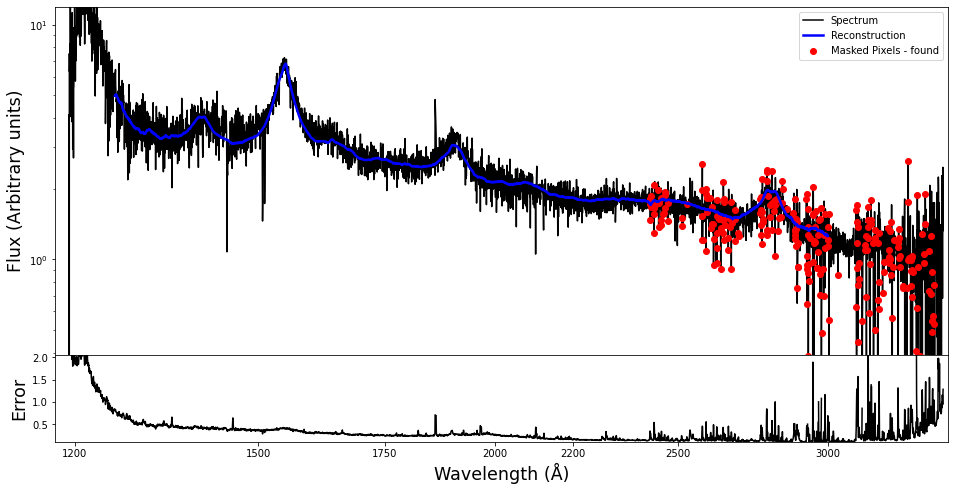

In [16]:
plot_ICA.spec_wreconstruction(waveSDSS, fluxSDSS_morph, errsSDSS_morph, maskSDSS, wave_morph_ica, flux_morph_ica)

---

Now see how spectrum changes with iterative masking.  This should be implemented in the actual script eventually, but want to visualize how things change with each step for now.

In [18]:
maskSDSS_witer = run_ICA_r20_components.maskIterate(waveSDSS, fluxSDSS_morph, errsSDSS_morph, maskSDSS, 
                                                    wave_morph_ica, flux_morph_ica)

Going to cut edges very crudely based on S/N of pixels around a given pixels.  Looking at the S/N array above however makes me think I should be smoothing over that, and cutting up until most of the pixels in a given window do not fall below the smoothed array -- similar to how Rankine+ are masking narrow absorption.

Only thing here is that it's not narrow absorption and so many downward pixels may drag down the median array.


In [81]:
s2n = fluxSDSS/errsSDSS
#s2n_median = spec_morph.cont_filtered(wave_cut*(1+zSDSS), s2n, zSDSS, "Nameless")
s2n_median = Small_Pix_Filter_TVM.SDSS_pixel_filter(wave_cut, s2n, 300)
errsSDSS_median = Small_Pix_Filter_TVM.SDSS_pixel_filter(waveSDSS, errsSDSS, 300)

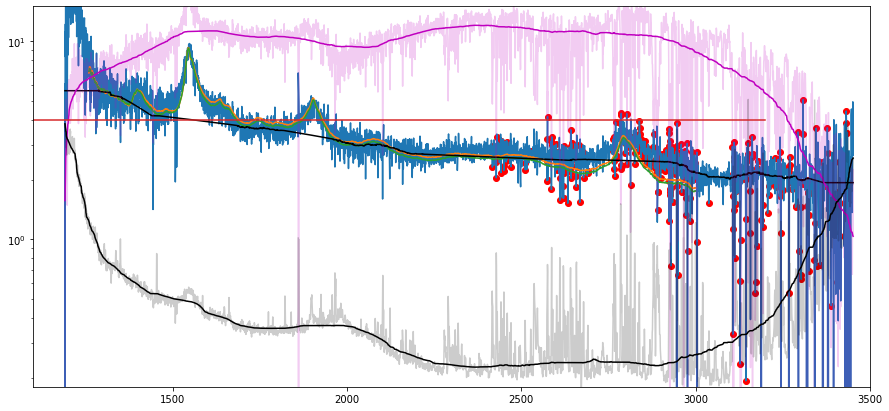

In [111]:
fig = plt.figure(figsize=(15,7))
plt.plot(waveSDSS, fluxSDSS, label="Spectrum")
plt.plot(wave_ica, flux_ica, label="Reconstruction")
plt.plot(wave_cut_ica, flux_cut_ica, label="Reconstruction, cut")
plt.plot(wave_cut, continuum_cut, "-k")
plt.scatter(waveSDSS[maskSDSS>0], fluxSDSS[maskSDSS>0], color="r", label="Masked pixels")

plt.plot(waveSDSS, s2n, alpha=0.2, color="m", label="S/N")
plt.plot(waveSDSS, s2n_median, color="m")

plt.plot(waveSDSS, errsSDSS, alpha=0.2, color="k", label="Error")
plt.plot(waveSDSS, errsSDSS_median, color="k", label="Error")

plt.plot([1000,3200], [4,4])

plt.yscale("log")
plt.ylim(.18,15)
plt.xlim(1100,3500)
#plt.legend(loc="upper right", prop={"size":20})
plt.show()

In [92]:
len(errsSDSS), len(errsSDSS_median)

(4620, 4620)

In [ ]:
len()

Need some sort of "scaled offset" from the median error or S/N array

In [104]:
scale_off_errs = []

#for i in range(len(errsSDSS)-1, 0, -1):
for i in range(len(errsSDSS)):
    #if errsSDSS[i]-errsSDSS_median[i]
    #print(i, errsSDSS_median[i]-errsSDSS[i], errsSDSS_median[i])
    #print((errsSDSS[i]-errsSDSS_median[i])/np.median(errsSDSS_median))
    scale_off_errs.append((errsSDSS[i]-errsSDSS_median[i])/np.nanmedian(errsSDSS_median))
    
scale_off_errs = np.array(scale_off_errs)

In [105]:
len(scale_off_errs)

4620

(-1.0, 8.0)

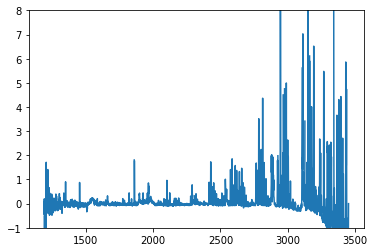

In [106]:
plt.plot(waveSDSS, scale_off_errs)
plt.ylim(-1,8)

In [108]:
min(waveSDSS), max(waveSDSS)

(1191.5406, 3451.5078)

In [114]:
for i in range(len(waveSDSS)-1, 0, -1):
    if (scale_off_errs[i-30:i+30]<2).sum()>59:
        print(waveSDSS[i])
        break

3084.671


Each pixel spans ~0.0001 in log(wavelength) space.  See if we can visualize how N pixels corresponds to linear wavelength.

In [117]:
obswave_sdss = np.arange(np.log10(3800/(1+2.)), np.log10(9200/(1+2.)), 0.0001)
obswave_sdss

array([3.10266234, 3.10276234, 3.10286234, ..., 3.48646234, 3.48656234,
       3.48666234])

In [118]:
obswave_sdss[0]

3.102662341897148

I think this does a sufficient job smoothing the S/N array (at least the one above).

Need to right some automated code that will cut this at ~2500 Å or ~2700Å.

In [75]:
l = [1,2,3,4,5,6]

In [77]:
l[4:12]

[5, 6]

---

Load in Paul's model continuum to morph to.

In [35]:
!ls components

amy_12603000_10c_180421.comp          wav_12603000.dat
amy_12653000_hew_hsn_7c_190302.comp   wav_12653000.dat
amy_12753000_lowew_10c_181101_v1.comp wav_12753000.dat
qsomod_z250_ng_continuumSDSSrebin.npy


In [36]:
qso_cont_morph = np.load("components/qsomod_z250_ng_continuumSDSSrebin.npy")

In [37]:
qso_cont_morph

array([[9.14955559e+02, 3.96711311e+00],
       [9.15166259e+02, 3.96707328e+00],
       [9.15377008e+02, 3.96703345e+00],
       ...,
       [1.19894704e+04, 1.02133131e-01],
       [1.19922314e+04, 1.02102094e-01],
       [1.19949930e+04, 1.02071050e-01]])

In [55]:
istart_morph  = np.argmin(abs(qso_cont_morph[:,0]-min(wave_cut)))
qso_morph_use = qso_cont_morph[istart_morph:istart_morph+len(wave_cut),:] 

In [56]:
qso_cont_morph.shape, qso_morph_use.shape, continuum_cut.shape, wave_cut.shape

((11177, 2), (4620, 2), (4620,), (4620,))

In [67]:
morph_array = Small_Pix_Filter_TVM.SDSS_pixel_filter(wave_cut, 
                        qso_morph_use[:,1]/continuum_cut*np.nanmedian(continuum_cut), 
                                                 npix=300)

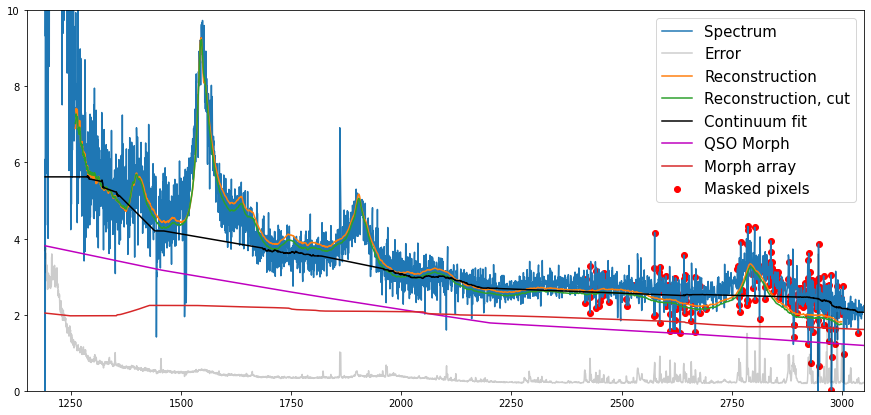

In [68]:
fig = plt.figure(figsize=(15,7))
plt.plot(waveSDSS, fluxSDSS, label="Spectrum")
plt.plot(waveSDSS, errsSDSS, alpha=0.2, color="k", label="Error")
plt.plot(wave_ica, flux_ica, label="Reconstruction")
plt.plot(wave_cut_ica, flux_cut_ica, label="Reconstruction, cut")
plt.plot(wave_cut, continuum_cut, "-k", label="Continuum fit")
plt.plot(qso_morph_use[:,0], qso_morph_use[:,1], "-m", label="QSO Morph")
plt.plot(wave_cut, morph_array, label="Morph array")
plt.scatter(waveSDSS[maskSDSS>0], fluxSDSS[maskSDSS>0], color="r", label="Masked pixels")
#plt.yscale("log")
plt.ylim(0,10)
plt.xlim(1150,3050)
plt.legend(loc="upper right", prop={"size":15})
plt.show()